In [1]:
%reset -sf
import sys
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from roughness import topoNshade as tns
from roughness import lineofsight as l
from roughness import roughness as r


In [2]:
def raytrace(dem,elev,azim):
    los=np.ones_like(dem)
    if (elev == 0):
        los=los
    else:
        los=l.lineofsight(dem.flatten(),elev,azim,los)
    return los.T

In [3]:
filepath=r.ROUGHNESS_DIR+'/data/sim_slopes.v1.hdf'
# Load in the hdf DEM files that Josh used to generate the shadow table.
hf = h5py.File(filepath, 'r')
# Grab the DEM, reshape, and transpose to make this identical to davinci.
data = np.array(hf['dem'][:]).reshape(10000,10000).T
# Grab the multiplication tables
RMSmult = np.array(hf['mult_factors']).reshape(10)

### Allocate the output arrays.
# RMS, inc
tot_shade=np.full((11,11),np.nan)

# out will hold shadowed fraction per slope/azim bin
# bin_pop will hold the total slope/azim bin counts
# RMS, azimuth, slope, inc
# nrms, ncinc, naz, ntheta
out=np.full((11,11,37,46),np.nan)
bin_pop=np.copy(out)
shade_pop=np.copy(out)

# This bit is to count the program's progess.
elems=46
itnum=0


In [4]:
# RMS mult is an array of coefficients to scale the DEM to the desired roughness
# Index = 0   1   2   3   4   5   6   7   8   9
# Rough = 5, 10, 15, 20, 25, 30, 35, 40, 45, 50  
i=4
dem=data*RMSmult[i]


In [5]:
# Incidence is computed in a strange way and I want to change it to be in increments of 5/10. 
#for j in range(2,11):    
#    inc=np.rad2deg(np.arccos((11-j)*0.1))
#    print(inc)
# Index =      2     3     4     5     6     7     8     9    10
# Incidence = 25.8, 36.8, 45.5, 53.1, 60.0, 66.4, 72.5, 78.4, 84.2
j=4
inc=np.rad2deg(np.arccos((11-j)*0.1))
print('Incidence angle for this j-value = ', inc)

Incidence angle for this j-value =  45.57299599919429


In [6]:
qbuffer=int(np.ceil(3.290527*2*np.std(dem)*np.tan(np.deg2rad(84))))
print('Longest shadow in pixels =',qbuffer)
print('If this is greater than ',dem.shape[1],' we have a problem...')
tmpshade=raytrace(dem,inc,270)

slope,azim=tns.gradSlopeAspect(dem)
slope=slope[:,qbuffer:-1]
azim=azim[:,qbuffer:-1]

Longest shadow in pixels = 925
If this is greater than  10000  we have a problem...


In [7]:
shademap=tmpshade[:,qbuffer:-1]
total_cells=shademap.shape[0]*shademap.shape[1]
illum_cells=np.sum(shademap.flatten())
shaded_cells=total_cells-illum_cells
print('Total cells = ',total_cells)
print('Illuminated cells = ', illum_cells)
print('Shaded cells = ', shaded_cells)
print('Total shade should be = ',shaded_cells/total_cells)
# tot_shade is just total shaded fraction as a function of incidence and roughness.
tot_shade[i,j-1]=shaded_cells/total_cells
print('But it is =',tot_shade[i,j-1])

Total cells =  90740000
Illuminated cells =  88777788.0
Shaded cells =  1962212.0
Total shade should be =  0.021624553669825877
But it is = 0.021624553669825877


In [8]:
if (tot_shade[i,j-1]>0):
            ##############################################################################
            ### k loop varies DEM slope and calculates azimuth bin shaded probability. ###
            for k in range(1,46):
                # Use the value of k to calculate the bin edges.
                minslope=k*2-3
                maxslope=k*2-1

                # Make a temporary azim array that we can mess with.
                temp_azim=np.copy(azim)
                # If the facet slope is out of our bin range set it to -10 so we can ignore it later.
                temp_azim[slope<minslope]=-10
                temp_azim[slope>=maxslope]=-10

                # If there are azimuths that have not been nulled, do some binning.
                if (np.max(temp_azim)> -10):
                    # Use histogram to make the azimuth bins for this slope bin.
                    azhist=np.histogram(temp_azim.flatten(),range=(-15,365),bins=38)[0][1:38]

                    # Add 0-5 and 355-360 bins to create identical endpoints needed for extrapolation
                    azhist[0]=azhist[0]+azhist[36]
                    azhist[36]=azhist[0]

                    # Where the DEM is not shadowed, nullify it and recalculate azim bins to calc probability
                    temp_azim[shademap==1]=-10
                    shadehist=np.histogram(temp_azim.flatten(),range=(-15,365),bins=38)[0][1:38]
                    shadehist[0]=shadehist[0]+shadehist[36]
                    shadehist[36]=shadehist[0]

                    bin_pop[i,j-1,:,k-1]=azhist
                    shade_pop[i,j-1,:,k-1]=shadehist
                    out[i,j-1,:,k-1]=(shadehist/azhist)

                    itnum=itnum+1
                    print(round((itnum/elems)*100,2),'%...........',end="\r",flush=True)

<ipython-input-8-f56b4c044a03>:32: RuntimeWarning: invalid value encountered in true_divide
  out[i,j-1,:,k-1]=(shadehist/azhist)


Text(0.5, 1.0, 'Shaded / Total(>50 counts)')

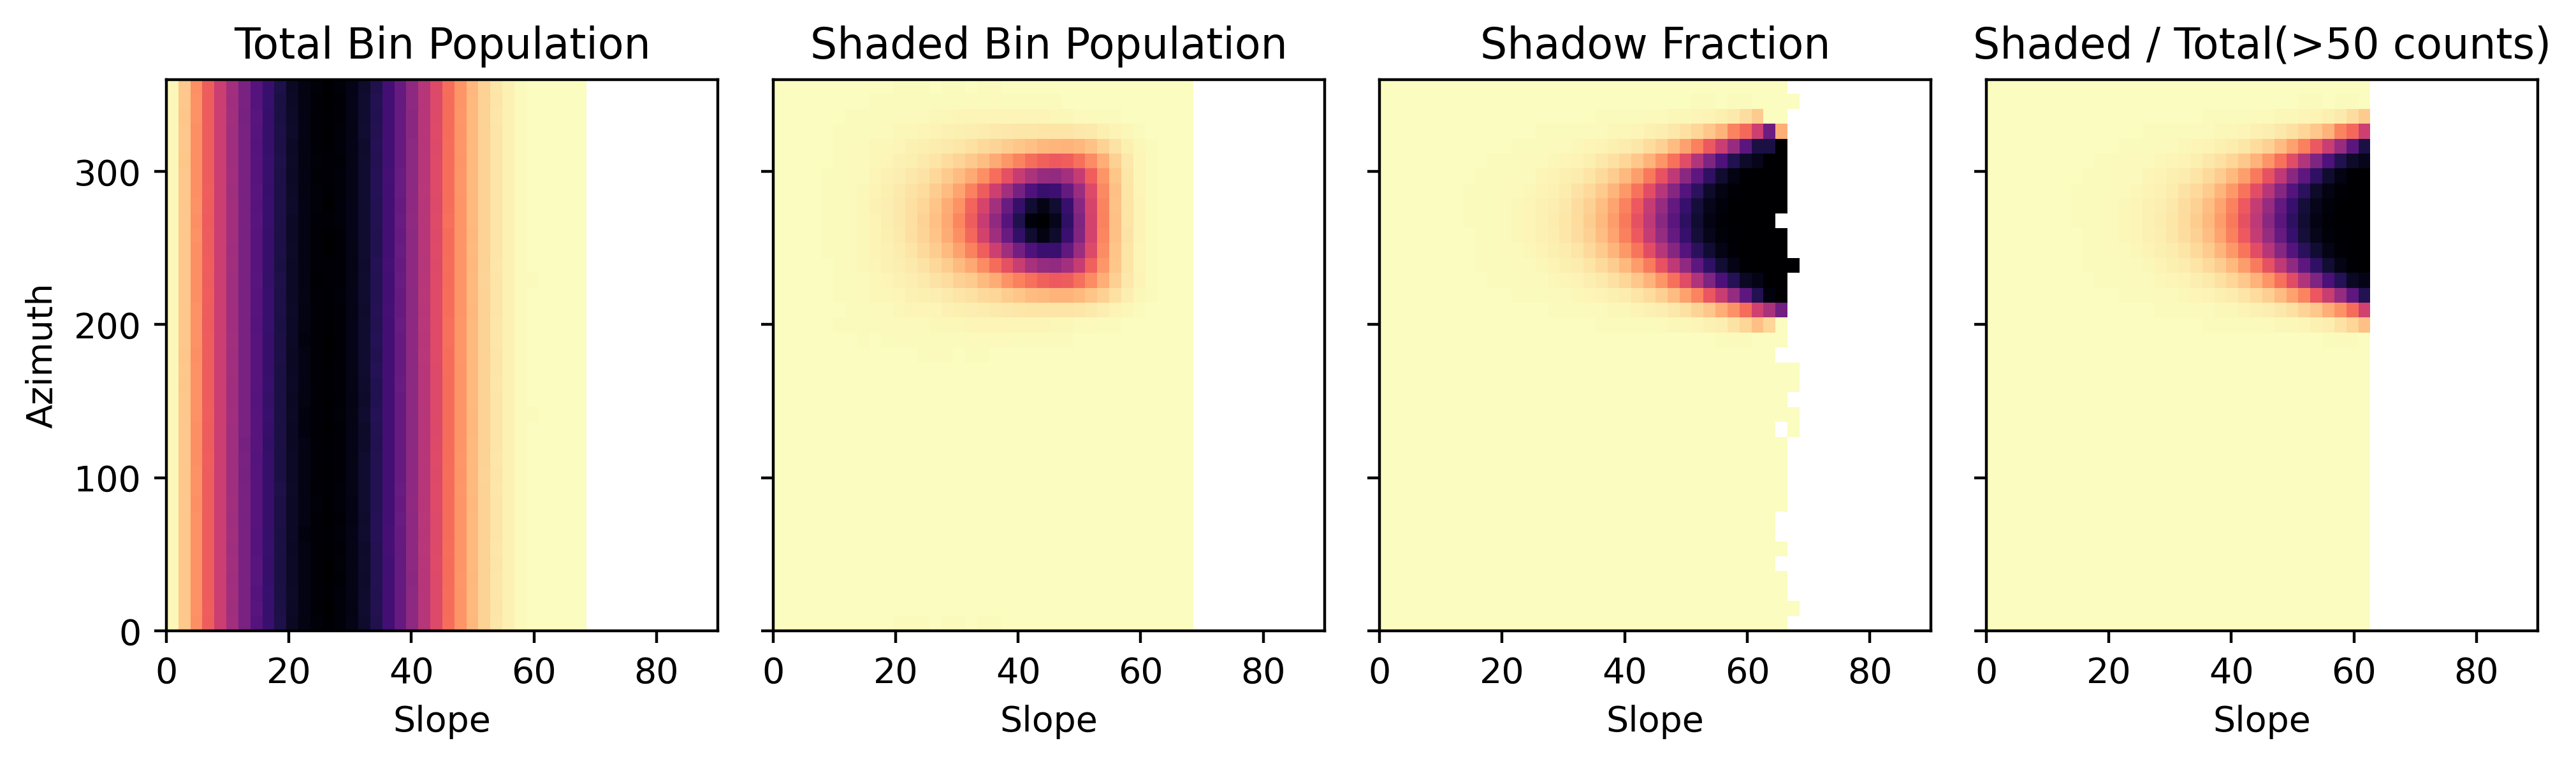

In [9]:
i=4
totbin=np.copy(bin_pop[i,j-1,:,:])
tmptotbin=np.copy(totbin)
tmptotbin[tmptotbin<=50]=np.nan

shadbin=np.copy(shade_pop[i,j-1,:,:])

shadfrac=np.copy(out[i,j-1,:,:])

cmap = cm.get_cmap("magma_r").copy()
cmap.set_bad(color='white')

fig,axes=plt.subplots(1,4,figsize=(12,5),dpi=400,sharey=True)
axes_flat=axes.ravel()
plt.subplots_adjust(wspace=.1)

axes_flat[0].imshow(totbin, extent=(0, 90, 0, 360), aspect=90 /360, cmap=cmap, vmin=0, vmax=np.nanmax(totbin))
axes_flat[0].set_ylabel('Azimuth')
axes_flat[0].set_xlabel('Slope')
axes_flat[0].set_title('Total Bin Population')

axes_flat[1].imshow(shadbin, extent=(0, 90, 0, 360), aspect=90 /360, cmap=cmap, vmin=0, vmax=np.nanmax(shadbin))
axes_flat[1].set_xlabel('Slope')
axes_flat[1].set_title('Shaded Bin Population')

axes_flat[2].imshow(shadfrac, extent=(0, 90, 0, 360), aspect=90 /360, cmap=cmap, vmin=0, vmax=1.0)
axes_flat[2].set_xlabel('Slope')
axes_flat[2].set_title('Shadow Fraction')

axes_flat[3].imshow(shadbin/tmptotbin, extent=(0, 90, 0, 360), aspect=90 /360, cmap=cmap, vmin=0, vmax=1.0)
axes_flat[3].set_xlabel('Slope')
axes_flat[3].set_title('Shaded / Total(>50 counts)')


In [10]:
bin_pop.shape

(11, 11, 37, 46)

(60.0, 75.0)

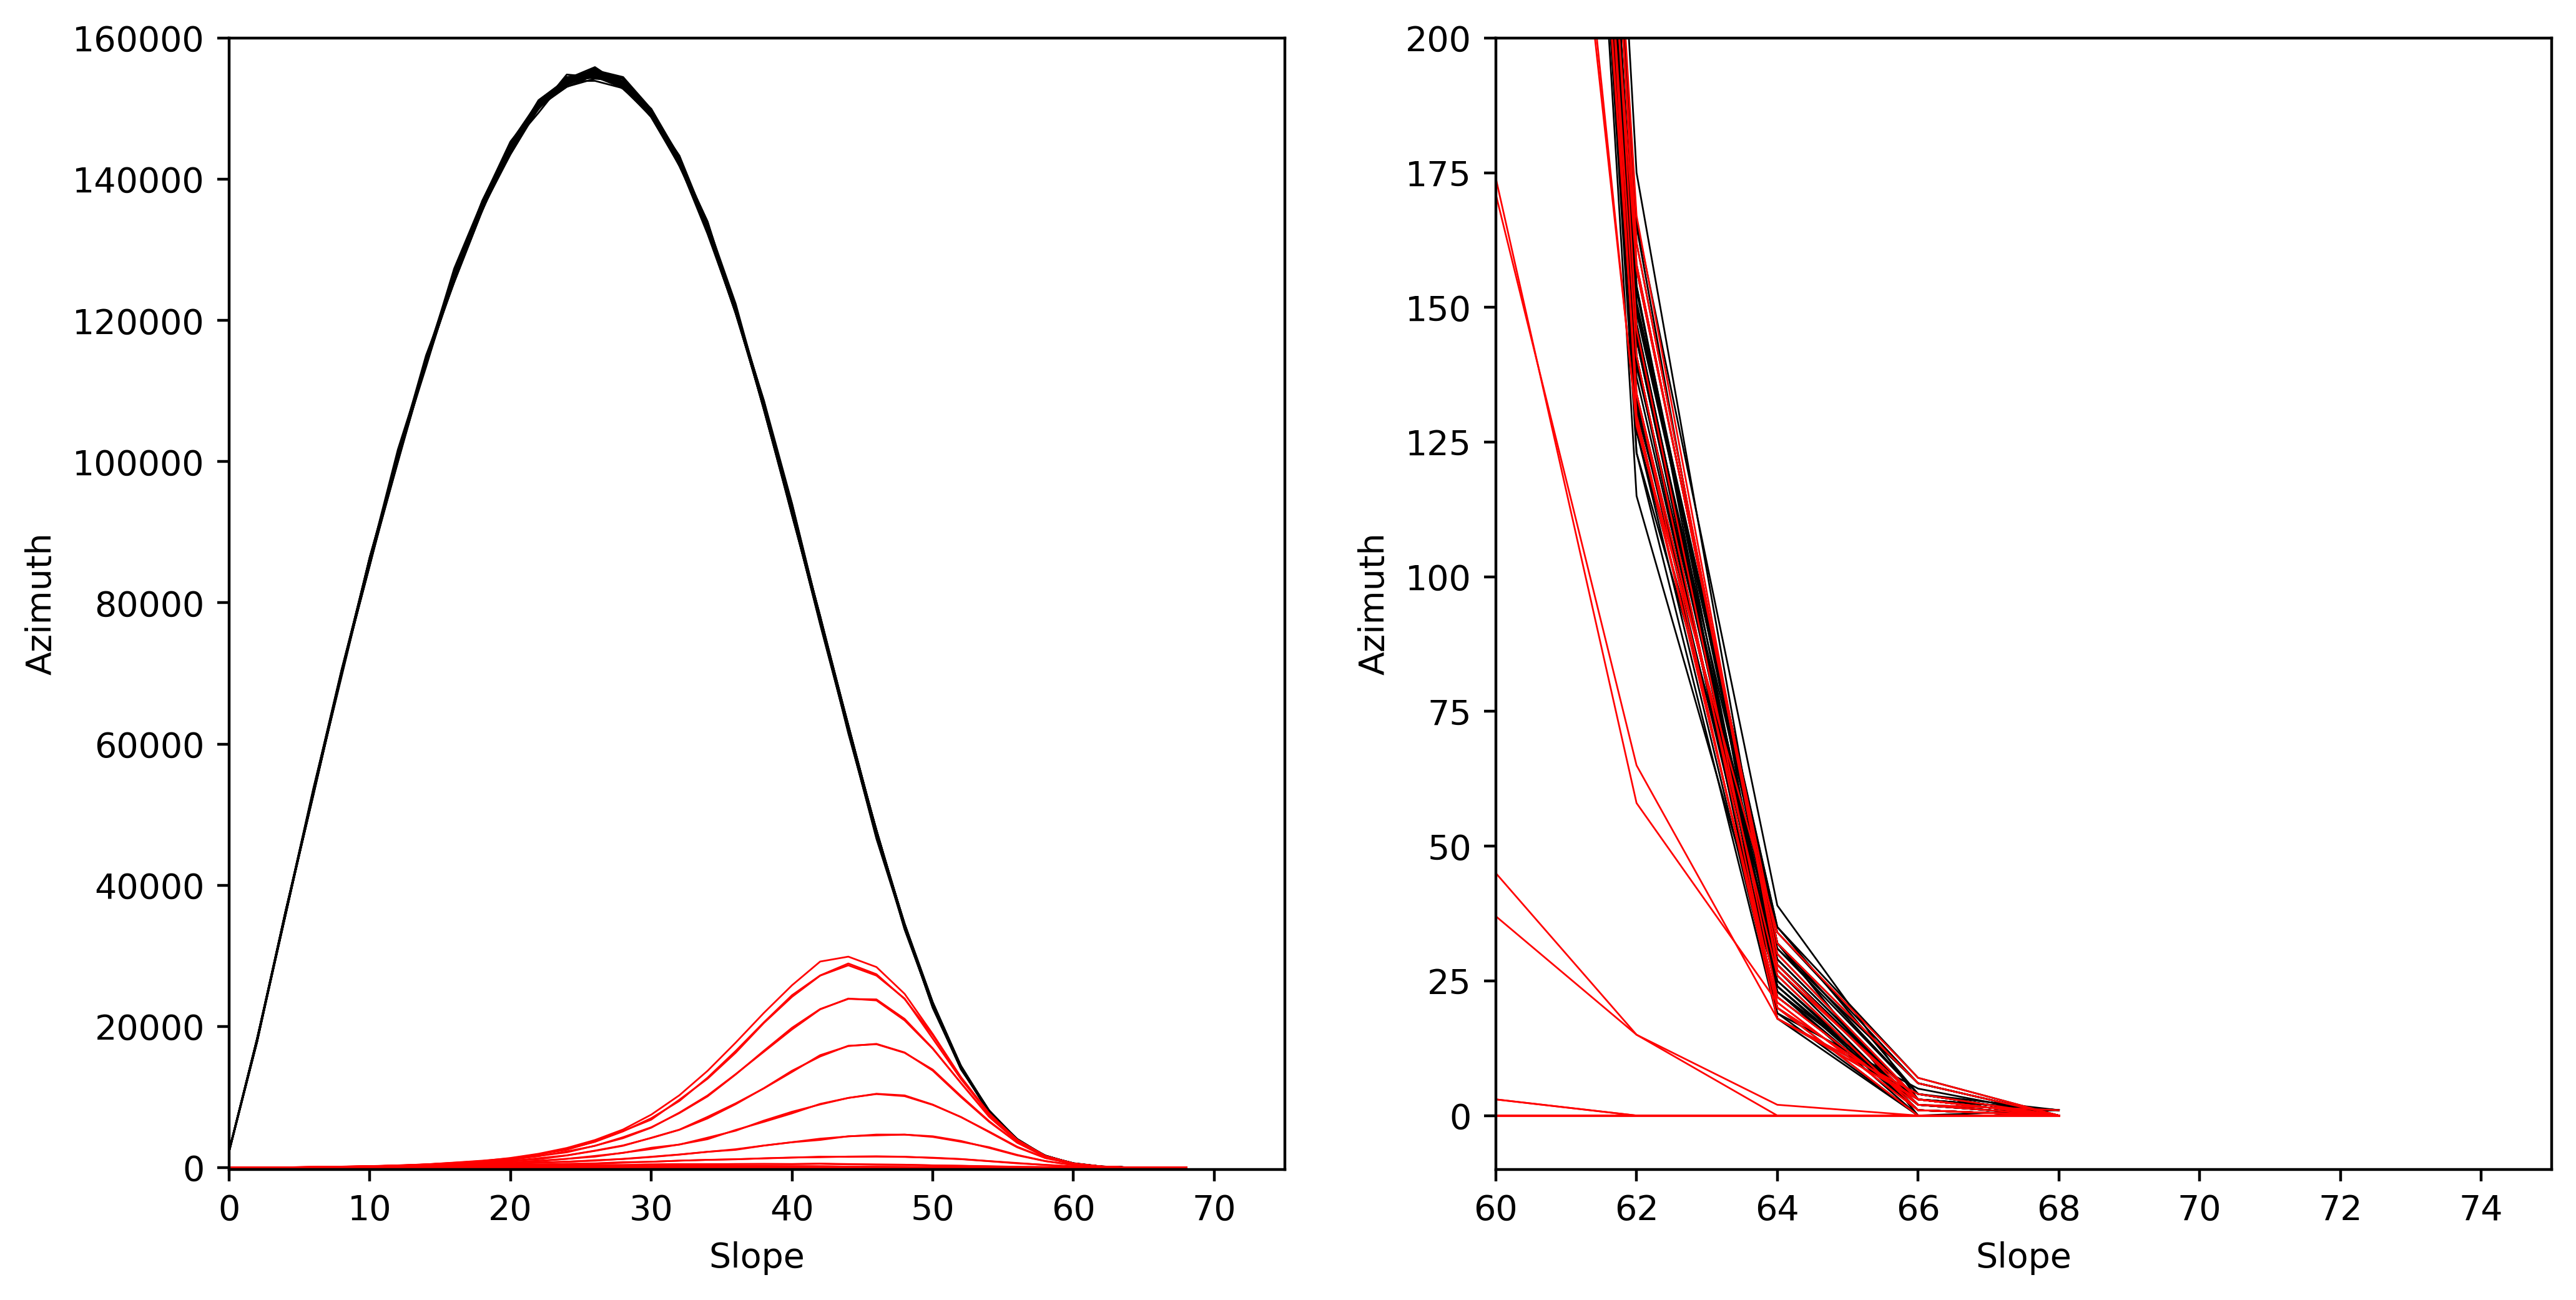

In [11]:
XX=np.arange(0,92,2)

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6),dpi=400)
for i in range(0,37):
    ax1.plot(XX,totbin[i,:],'k',lw=0.5)
for i in range(0,37):
    ax1.plot(XX,shadbin[i,:],'r',lw=0.5)
    
ax1.set_ylabel('Azimuth')
ax1.set_xlabel('Slope')
ax1.set_ylim(-250,160000)
ax1.set_xlim(0,75)

for i in range(0,37):
    ax2.plot(XX,totbin[i,:],'k',lw=0.5)
for i in range(0,37):
    ax2.plot(XX,shadbin[i,:],'r',lw=0.5)
    
ax2.set_ylabel('Azimuth')
ax2.set_xlabel('Slope')
ax2.set_ylim(-10,200)
ax2.set_xlim(60,75)
